# <center><span style="font-family: ClearSans-Bold, sans-serif; color:#FA8072">Leveraging Profit Scoring in Digital Loan Underwriting</span></center>

<span style="font-family: ClearSans, sans-serif; color:navyblue">Profit scoring model prototype using Credit Risk Modeling Dataset retrieved from a leading European P2P lending platform [Bondora](https://www.bondora.com/en/public-reports#dataset-file-format).

<span style="font-family: ClearSans, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [ ]:
%%capture
!pip install pandas numpy pyarrow matplotlib scikit-learn scipy lightgbm shap

In [18]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'retina'

### Import data

In [15]:
parquet_file = 'https://github.com/deburky/profit-scoring/blob/main/bondora_dataset/Bondora_dataset.parquet?raw=true'
data = pd.read_parquet(parquet_file, engine='auto')

In [16]:
data.head(n=1)

,PartyId,LoanId,LoanNumber,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanDate,ApplicationSignedHour,ApplicationSignedWeekday,...,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan,is_default,ARR,risk_adj_ARR
0,{1AD71AF0-8240-4700-B602-ADA90177DD8C},D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,11,0.0,88.0,Existing_credit_customer,2022-09,12,6,...,237.68,710.12,1.0,3402.0,1161.57,0.0,0.0,0,0.226369,0.11988


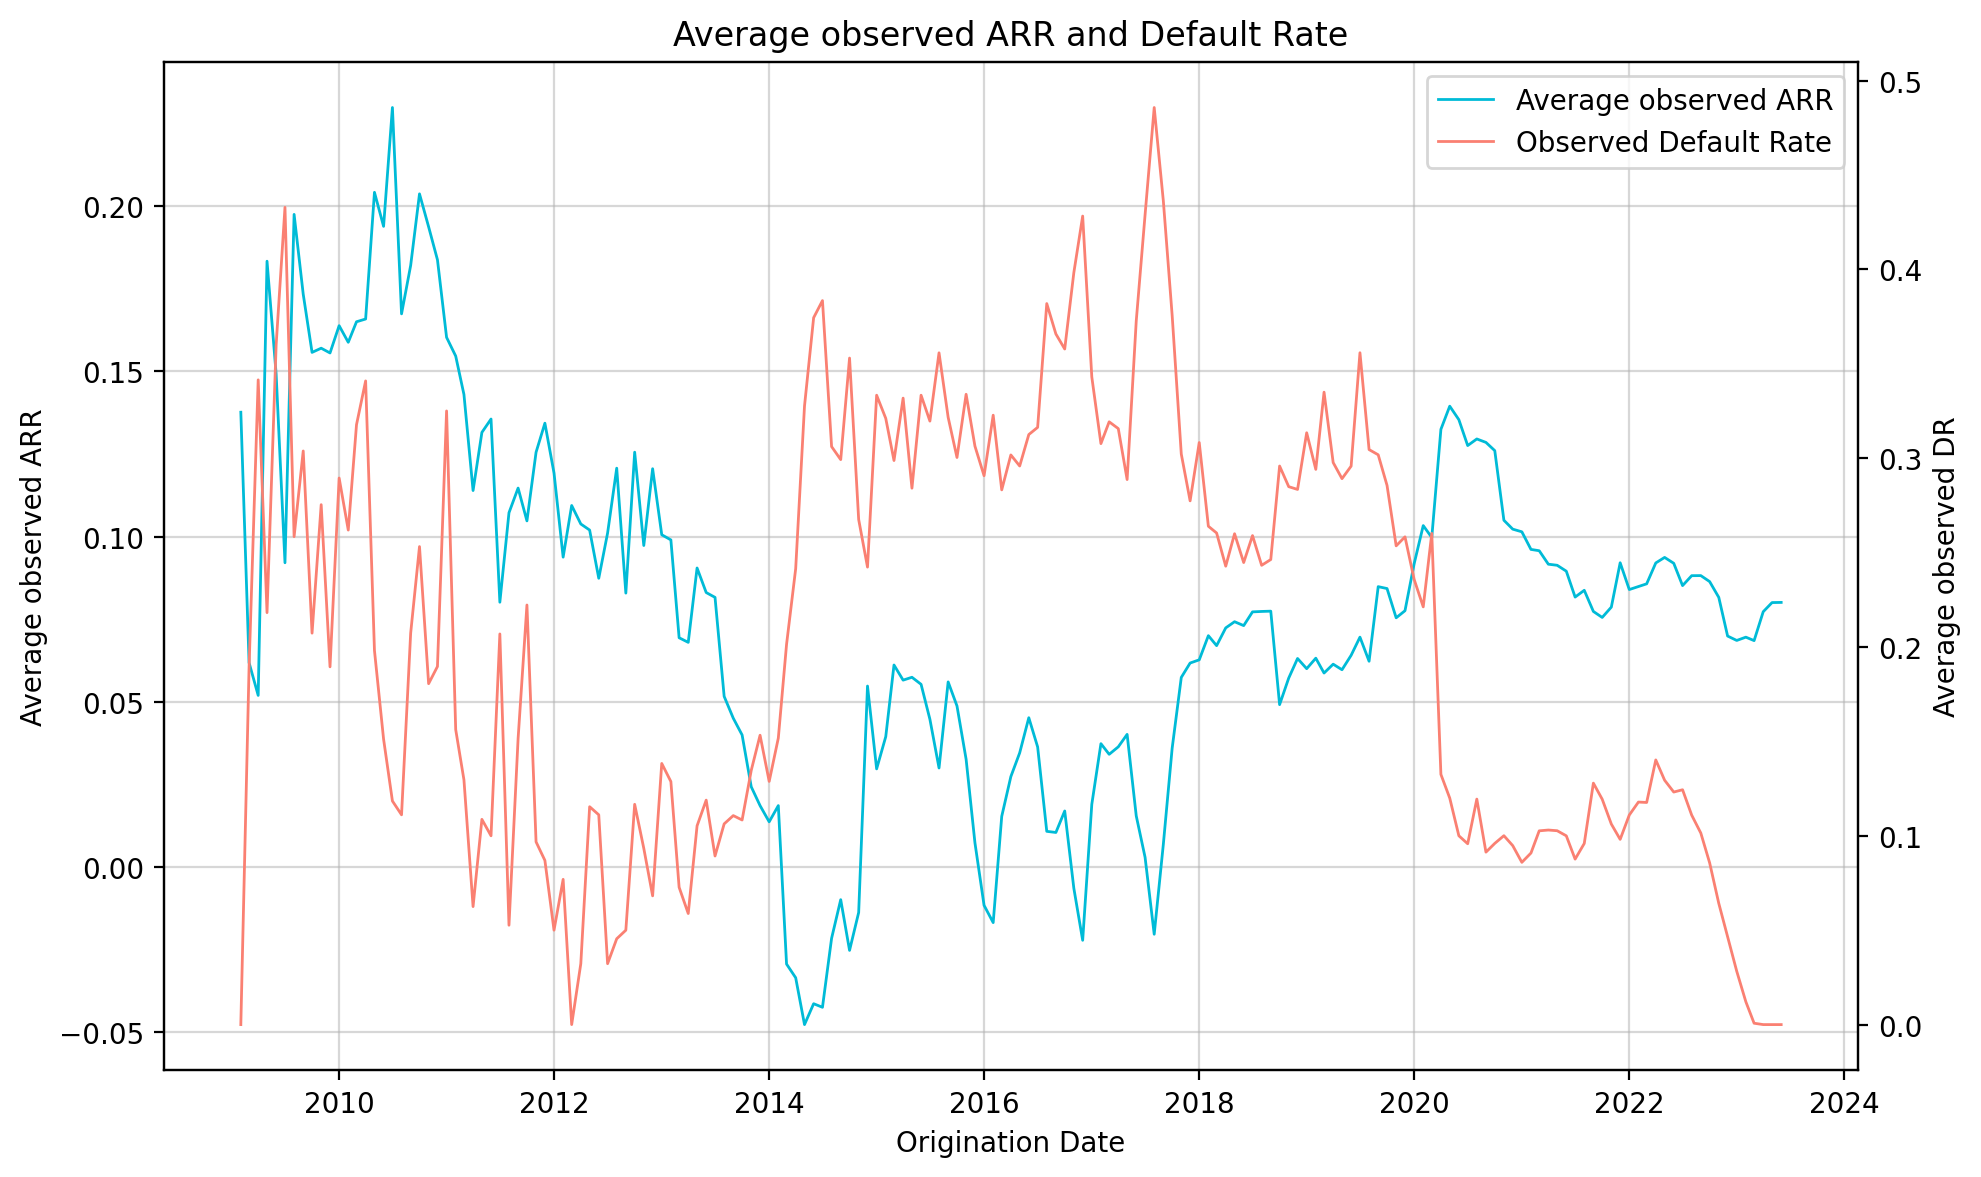

In [20]:
# Group and aggregate the data
grouped_data = data.groupby('LoanDate').agg(
    arr_obs=('risk_adj_ARR', 'mean'),
    odr=('is_default', 'mean'),
)

# Convert the Period values to numeric representation
x_values = grouped_data.index.to_timestamp()
kwargs = {'linestyle':'-', 'linewidth':1}
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average observed ARR
ax1.plot(x_values, grouped_data['arr_obs'],
    color='#00BBD7', label='Average observed ARR', **kwargs)

# Set the title and labels for the first axis
ax1.set_title('Average observed ARR and Default Rate')
ax1.set_xlabel('Origination Date')
ax1.set_ylabel('Average observed ARR')

# Create the second axis
ax2 = ax1.twinx()

# Plot the observed default rate
ax2.plot(x_values, grouped_data['odr'],
    color='#FA8072', label='Observed Default Rate', **kwargs)
ax2.set_ylabel('Average observed DR')

# Combine the legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2)

# Add grid lines
ax1.grid(True, linestyle='-', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [21]:
variables = [
    'BidsPortfolioManager', 'BidsApi', 'BidsManual', 
    'NewCreditCustomer', 'ApplicationSignedHour',
    'ApplicationSignedWeekday', 'VerificationType', 
    'LanguageCode', 'Age', 'Gender', 'UseOfLoan', 
    'Education', 'MaritalStatus', 'NrOfDependants',
    'EmploymentStatus', 'EmploymentDurationCurrentEmployer',
    'OccupationArea', 'HomeOwnershipType', 'IncomeFromPrincipalEmployer',
    'IncomeFromPension', 'IncomeFromFamilyAllowance',
    'IncomeFromSocialWelfare', 'IncomeFromLeavePay',
    'IncomeFromChildSupport', 'IncomeOther', 'IncomeTotal',
    'ExistingLiabilities', 'LiabilitiesTotal', 'RefinanceLiabilities',
    'DebtToIncome', 'FreeCash', 'MonthlyPaymentDay', 
    'Restructured', 'CreditScoreEsMicroL', 'PrincipalPaymentsMade',
    'InterestAndPenaltyPaymentsMade', 'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan', 'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsBefoleLoan','PreviousEarlyRepaymentsCountBeforeLoan',
    'risk_adj_ARR'
    ]

In [22]:
dataset = data[variables].copy()

In [23]:
variables.remove('risk_adj_ARR')
feats_cat = dataset.select_dtypes(include=[object]).columns
feats_num = list(set(variables) - set(feats_cat))
features = [*feats_num, *feats_cat]

### Sampling

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# features and target
X = dataset[features + ['risk_adj_ARR']].copy()
y = X.pop('risk_adj_ARR')

# sampling (train / test / hold-out)
ix_train, ix_test = train_test_split(
    X.index,
    test_size=0.3, 
    random_state=24)

print(f"Train: {len(ix_train):,.0f}\nTest: {len(ix_test):,.0f}")

Train: 217,558
Test: 93,240


### Linear model

In [26]:
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from scipy.stats import somersd

In [27]:
def smdcr(y_true: np.array or pd.Series, 
          y_pred: np.array or pd.Series) -> float:
    """
    Calculate Somers D x|y

    Args:
        y_true: Observed target values
        y_pred: Predictions

    Returns:
        Somers D statistic

    Comments:
    Note that the definition of Somers D is asymmetric: in general, smdcr(y_true, y_pred) != smdcr(y_pred, y_true).
    smdcr(y_true, y_pred) calculates Somers’ D, where the "row" variable y_true is treated as an independent variable,
    and the "column" variable y_pred is dependent.

    References:
        Somers, R. H. (1962). A new asymmetric measure of association for ordinal variables.
        American Sociological Review, 27(6), 799–811.

    """
    # calculate bins
    min_est = y_pred.min()
    max_est = y_pred.max()
    est_int = (max_est - min_est) / 10
    bins = [min_est + est_int * i for i in range(1, 11)]

    # bucket observations
    y_pred_binned = np.maximum(1, np.digitize(y_pred, bins=bins, right=False))
    y_true_binned = np.maximum(1, np.digitize(y_true, bins=bins, right=False))

    # contingency tab
    table = pd.crosstab(y_pred_binned, y_true_binned)

    # # somers d
    smdcr = somersd(table)
    return smdcr.statistic

In [28]:
# one-hot encoding categorical features
transformer = ColumnTransformer(
    transformers=[('OneHotEncoder', 
                   OneHotEncoder(drop='first', handle_unknown='ignore'), feats_cat)], 
                                 remainder='passthrough', 
                                 verbose_feature_names_out=False)

# creating a pipeline
sklearn_pipe = make_pipeline(
    transformer,
    Ridge(alpha=15))

sklearn_pipe.fit(X.loc[ix_train], y.loc[ix_train].to_numpy().ravel())

smdcr_test = smdcr(y.loc[ix_test], sklearn_pipe.predict(X.loc[ix_test]))
print(f"Somers D: {smdcr_test:.2%}")

Somers D: 52.94%


### Tree-based model

In [29]:
import lightgbm as lgb

In [30]:
# preprocess categorical feats for lgb
for c in feats_cat:
    X[c] = X[c].astype('category')

In [31]:
params = {
    "objective": "regression",
    "num_leaves": 50,
    "n_estimators": 100,
    "learning_rate": 0.5,
    "max_depth": 3,
    "verbosity": -1,
    "random_state": 62
}

lgb_reg = lgb.LGBMRegressor(**params)
lgb_reg.fit(X.loc[ix_train], 
            y.loc[ix_train].to_numpy().ravel(),
            categorical_feature=list(feats_cat))

smdcr_test = smdcr(y.loc[ix_test], lgb_reg.predict(X.loc[ix_test]))
print(f"Somers D: {smdcr_test:.2%}")

/Users/deburky/miniconda3/envs/my_x86_env/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Somers D: 61.14%


#### Diagnostics

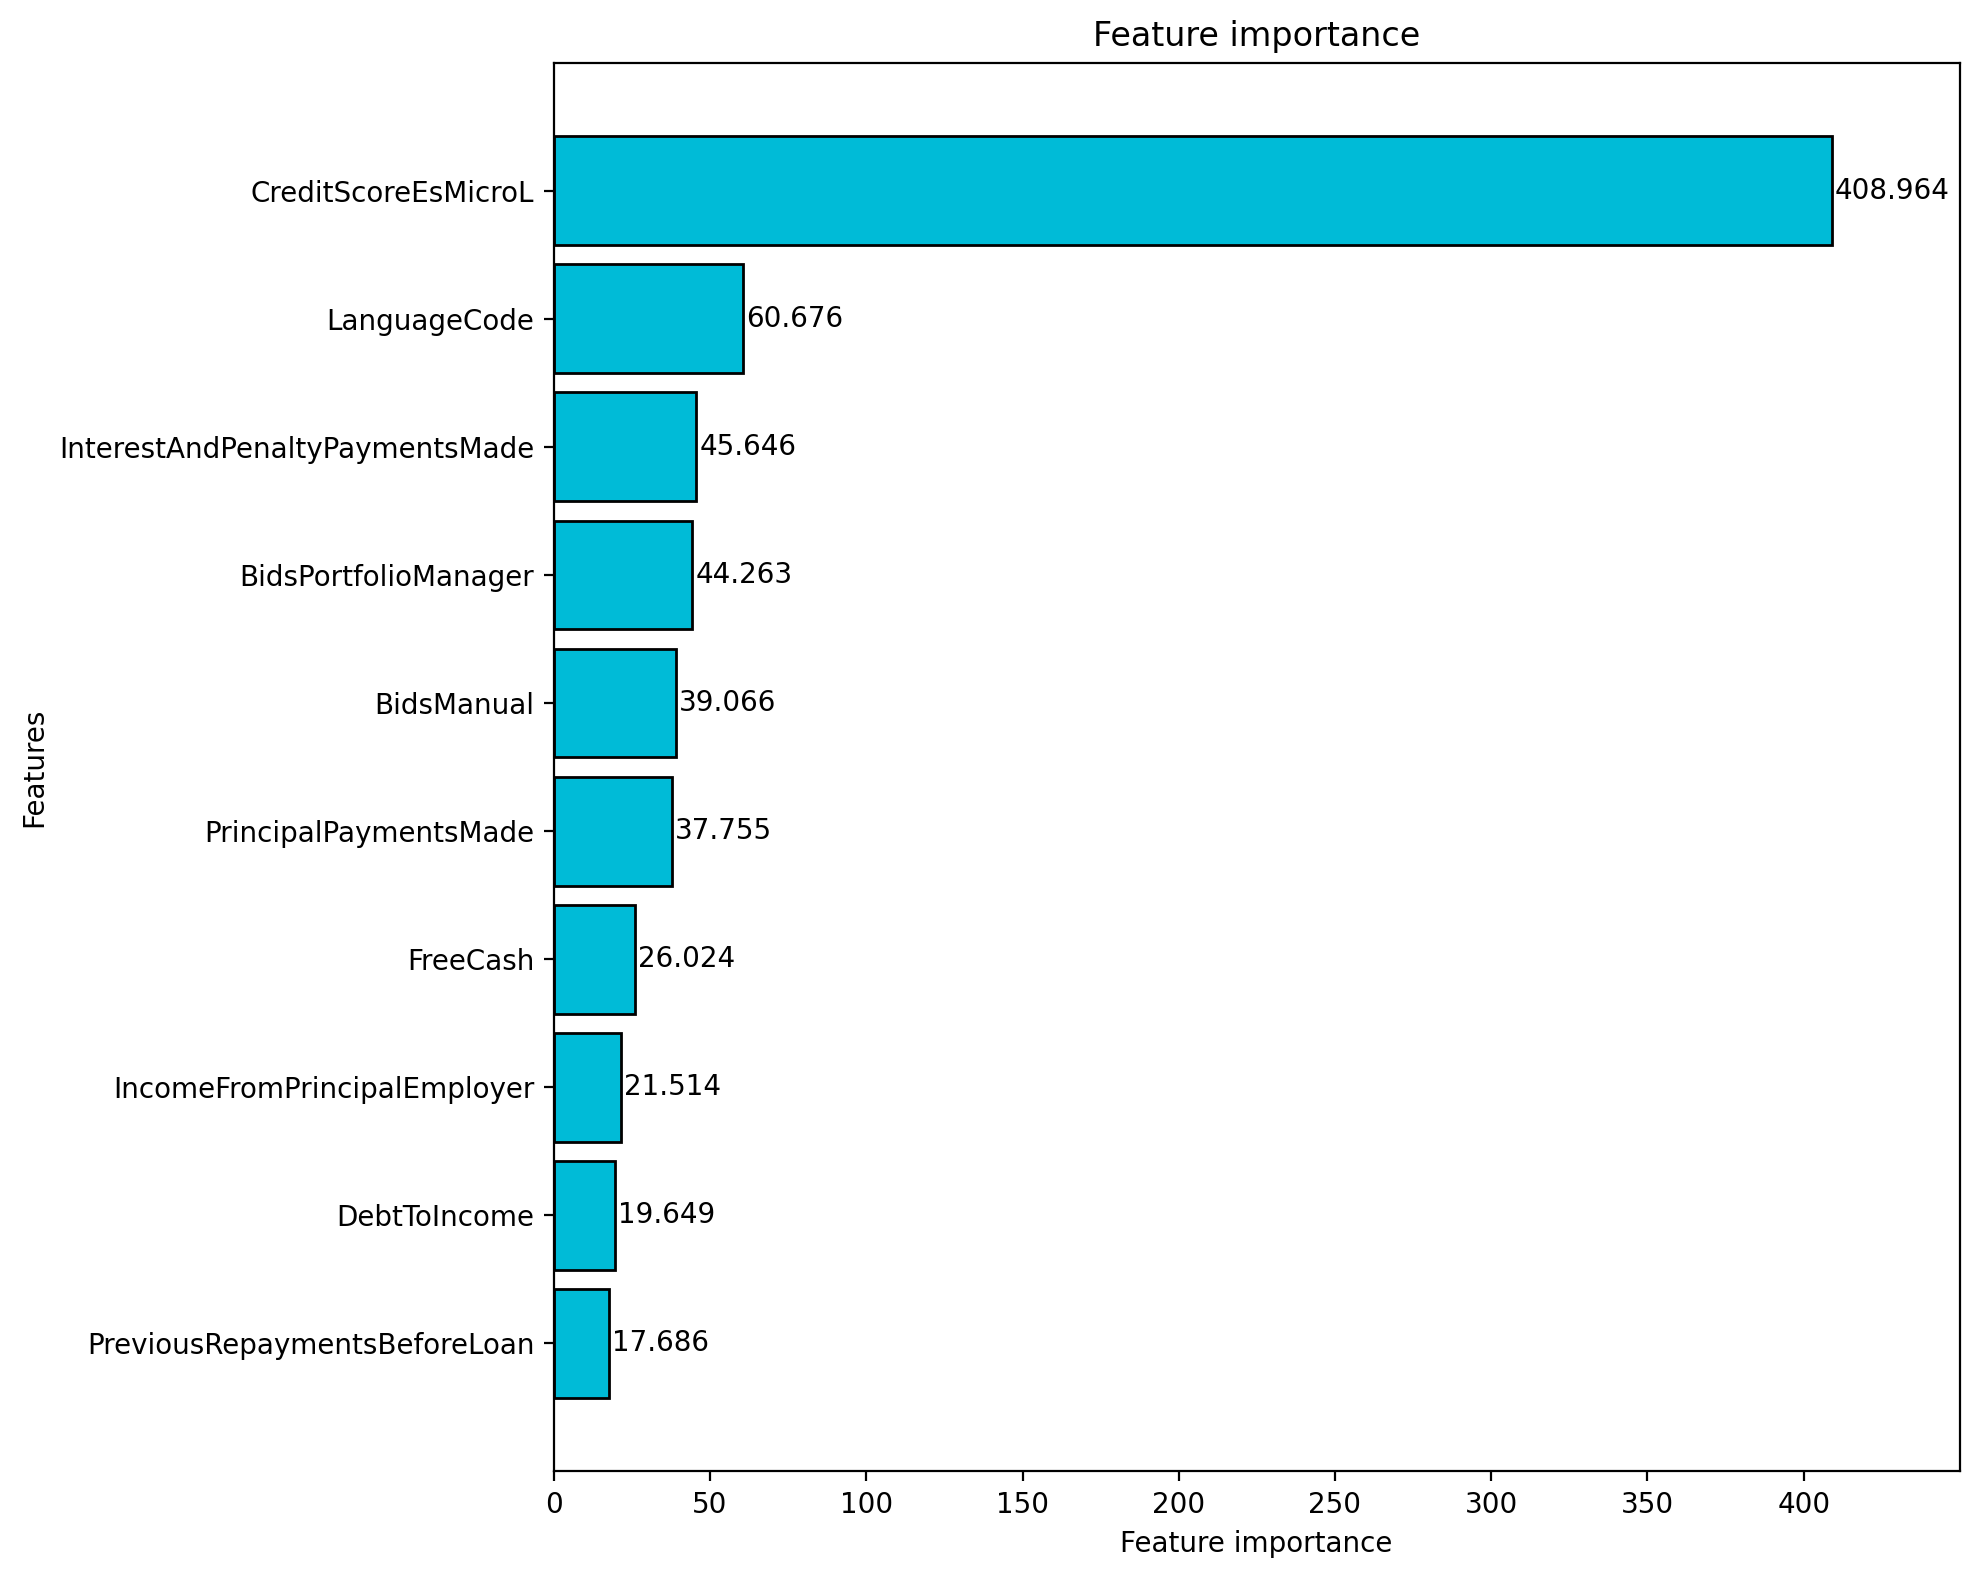

In [32]:
lgb.plot_importance(lgb_reg, 
                    importance_type='gain', 
                    max_num_features=10,
                    height=0.85, 
                    color='#00BBD7', 
                    edgecolor='black', 
                    grid=False,
                    figsize=(10,8))
plt.tight_layout()
plt.show()

#### ARR buckets

In [33]:
# get feature names
boost = lgb_reg.booster_
feature_names = boost.feature_name()

# preprocess categorical feats for lgb
for c in feats_cat:
    data[c] = data[c].astype('category')

In [34]:
# predict
data['ARR_prediction'] = lgb_reg.predict(data[feature_names])

# create bins
min_est = data['ARR_prediction'].min()
max_est = data['ARR_prediction'].max()
est_int = (max_est - min_est) / 10
bins = [min_est + est_int * i for i in range(1, 11)]

data['ARR_rating'] = np.digitize(data['ARR_prediction'], bins=bins, right=True)
data['ARR_rating'] = (np.max(data['ARR_rating']) - data['ARR_rating'])+1

In [35]:
data.groupby('ARR_rating').agg(
    avg_arr_obs = ('risk_adj_ARR', 'mean'),
    avg_arr_pred = ('ARR_prediction', 'mean'),
    n_obs = ('ARR_prediction', 'count')
    )

,avg_arr_obs,avg_arr_pred,n_obs
ARR_rating,,,
1,0.263522,0.288922,97
2,0.168265,0.163954,4329
3,0.080833,0.080666,289687
4,-0.024048,-0.026281,11092
5,-0.173707,-0.165235,4081
6,-0.293689,-0.275630,1051
7,-0.437904,-0.402733,305
8,-0.569500,-0.523783,122
9,-0.602097,-0.632924,24


In [36]:
corr_coef = data[['ARR_prediction', 'risk_adj_ARR']].corr(method='spearman').unstack()[1]
print(f"Spearman rho: {corr_coef:.2%}")

Spearman rho: 57.58%


#### Comparison with PD rating scale
In this step we would like to compare ARR ratings against PD ratings

In [37]:
# map to a rating scale
rating_scale = [0.001, 0.02, 0.03, 0.049, 0.071, 0.1055, 0.2000, 0.4754, 0.7000]
data['PD_rating'] = np.digitize(data['pd'], rating_scale, right=False) + 1

In [38]:
# create a pivot view
pivot_table = pd.pivot_table(
    data, 
    values='risk_adj_ARR',
    index='ARR_rating', 
    columns='PD_rating', 
    aggfunc=np.mean,
    fill_value=0 # np.nan
    )

pivot_table.style.format('{:,.2%}').background_gradient(cmap="cividis")

PD_rating,1,2,3,4,5,6,7,8,9,10
ARR_rating,,,,,,,,,,
1,32.50%,0.00%,0.00%,0.00%,0.00%,0.00%,26.22%,0.00%,0.00%,0.00%
2,21.34%,16.08%,18.21%,17.51%,14.20%,14.58%,17.92%,14.40%,10.53%,19.81%
3,19.06%,6.30%,8.16%,8.39%,8.84%,9.15%,8.12%,7.36%,3.19%,7.58%
4,12.19%,6.31%,2.30%,4.27%,4.39%,3.97%,2.66%,-1.93%,-9.82%,-26.29%
5,6.80%,0.00%,-30.66%,-13.78%,-2.97%,-3.49%,-2.56%,-15.32%,-16.11%,-26.83%
6,-43.40%,0.00%,0.00%,0.00%,-56.89%,-2.05%,-17.97%,-24.01%,-36.75%,-31.90%
7,-45.25%,0.00%,0.00%,0.00%,0.00%,0.00%,-28.92%,-29.08%,-50.64%,-45.21%
8,-57.80%,0.00%,0.00%,0.00%,0.00%,0.00%,-94.29%,-38.43%,-54.75%,-69.46%
9,-55.84%,0.00%,0.00%,0.00%,0.00%,0.00%,-67.50%,-46.47%,-58.91%,-73.40%


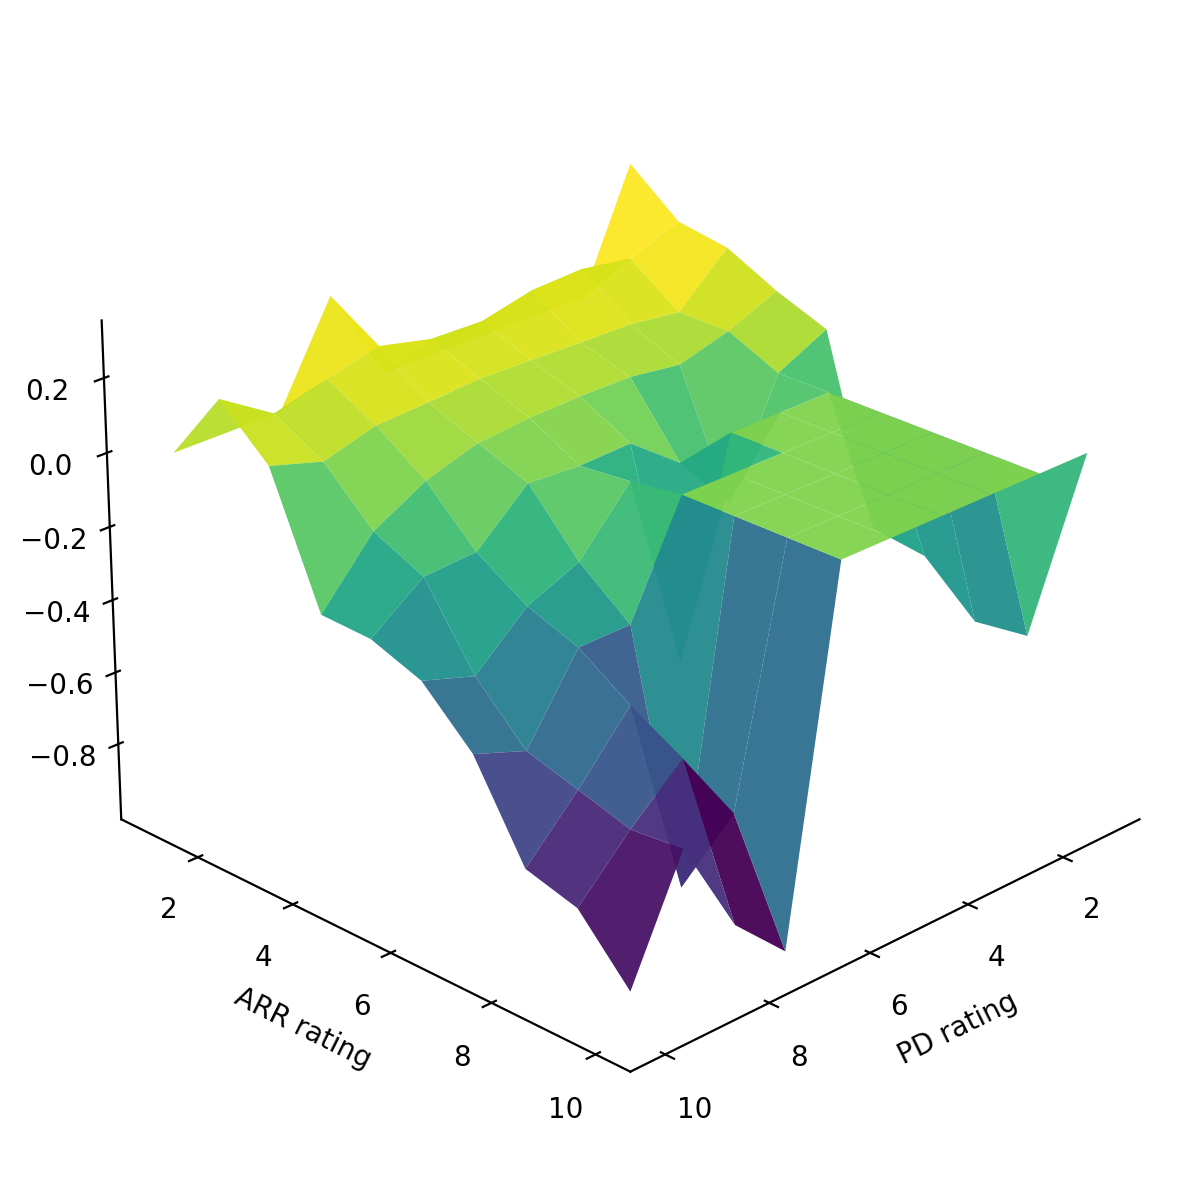

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X_ = pivot_table.columns.astype(int)
Y_ = pivot_table.index.astype(int)
Z_ = pivot_table.values

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X_, Y_ = np.meshgrid(X_, Y_)
ax.plot_surface(X_, Y_, Z_, cmap='viridis', alpha=0.95)

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)

# Set the labels and title
ax.set_xlabel('PD rating')
ax.set_ylabel('ARR rating')

ax.view_init(azim=45, elev=25)

# Show the plot
plt.tight_layout()
plt.show()

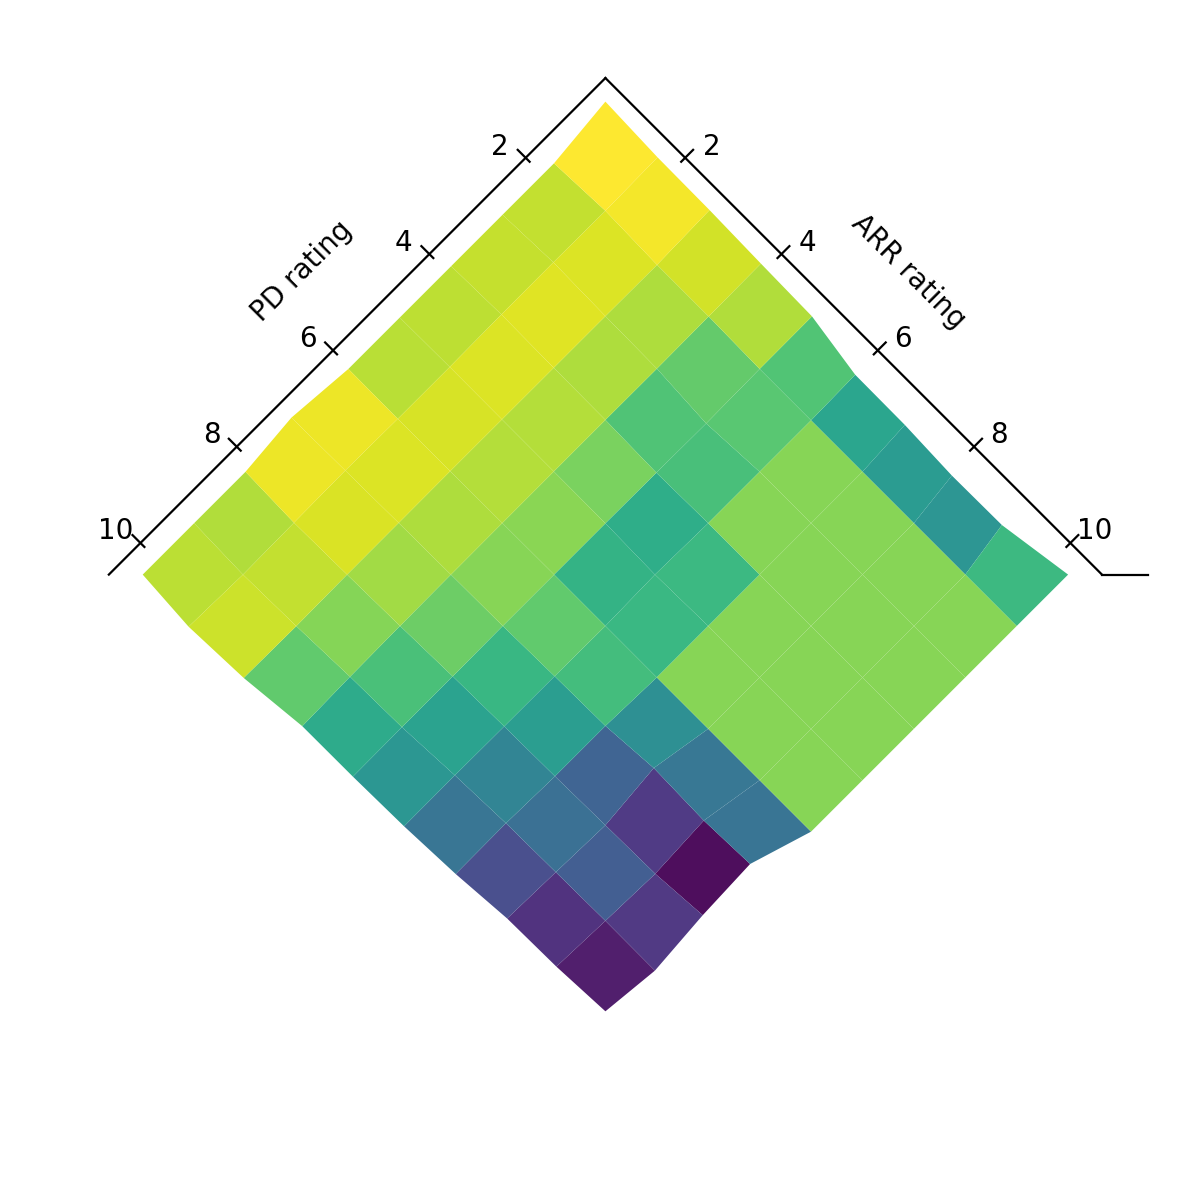

In [40]:
X_ = pivot_table.columns.astype(int)
Y_ = pivot_table.index.astype(int)
Z_ = pivot_table.values

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X_, Y_ = np.meshgrid(X_, Y_)
ax.plot_surface(X_, Y_, Z_, cmap='viridis', alpha=0.95)

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Bonus: To get rid of the grid as well:
ax.grid(False)

# Set the labels and title
ax.set_xlabel('PD rating')
ax.set_ylabel('ARR rating')
# ax.set_zlabel('ARR')

ax.view_init(azim=45, elev=90)
ax.set_zticks([])

# Show the plot
plt.tight_layout()
plt.show()

### Comparison with credit scoring

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

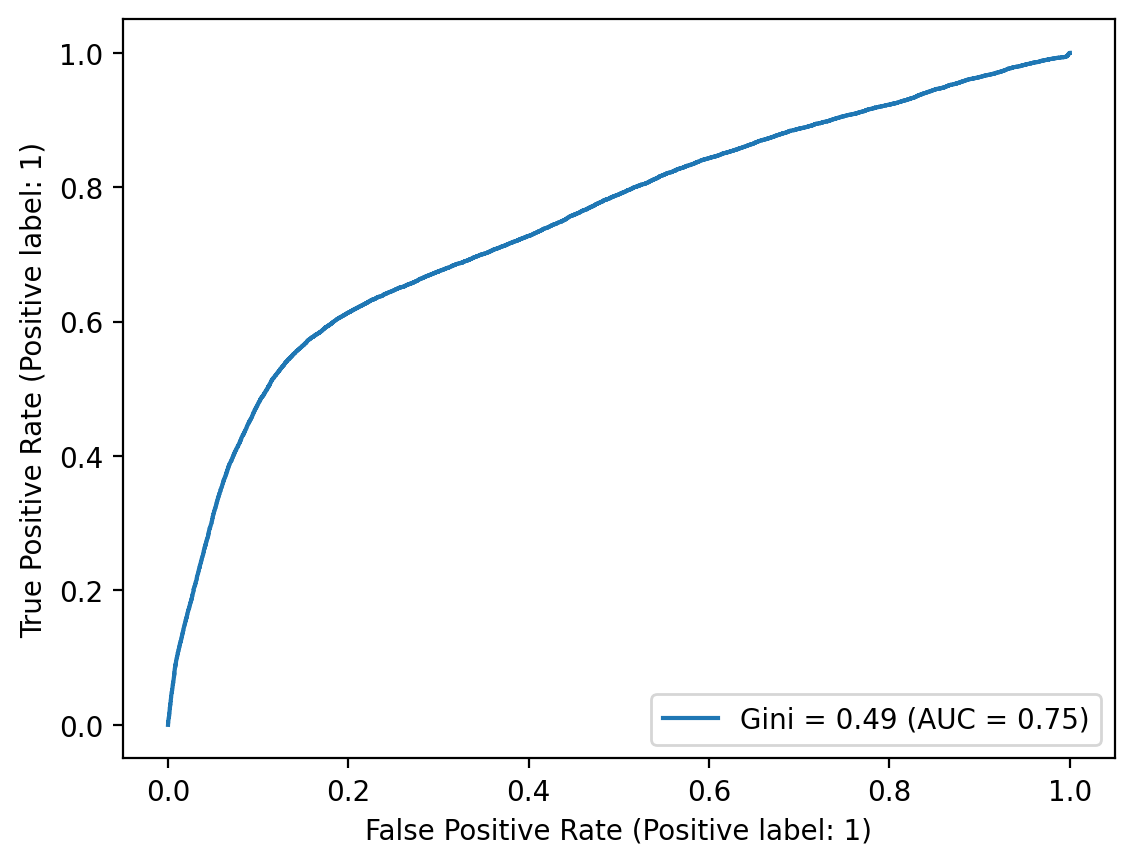

In [42]:
gini = roc_auc_score(data.loc[ix_test]['is_default'], 
                     -data.loc[ix_test]['ARR_prediction'])*2-1

RocCurveDisplay.from_predictions(
    data.loc[ix_test]['is_default'], 
    -data.loc[ix_test]['ARR_prediction'],
    name=f"Gini = {gini:.2f}")

plt.show()

In [43]:
gini_bond = roc_auc_score(data.loc[ix_test]['is_default'], 
                     data.loc[ix_test]['pd'])*2-1
print(f"Gini of Bondora PD model: {gini_bond:.2f}")

Gini of Bondora PD model: 0.49


### Intra-period explanations with SHAP
Which factors drove down ARR in 2014-2015?

In [44]:
import shap

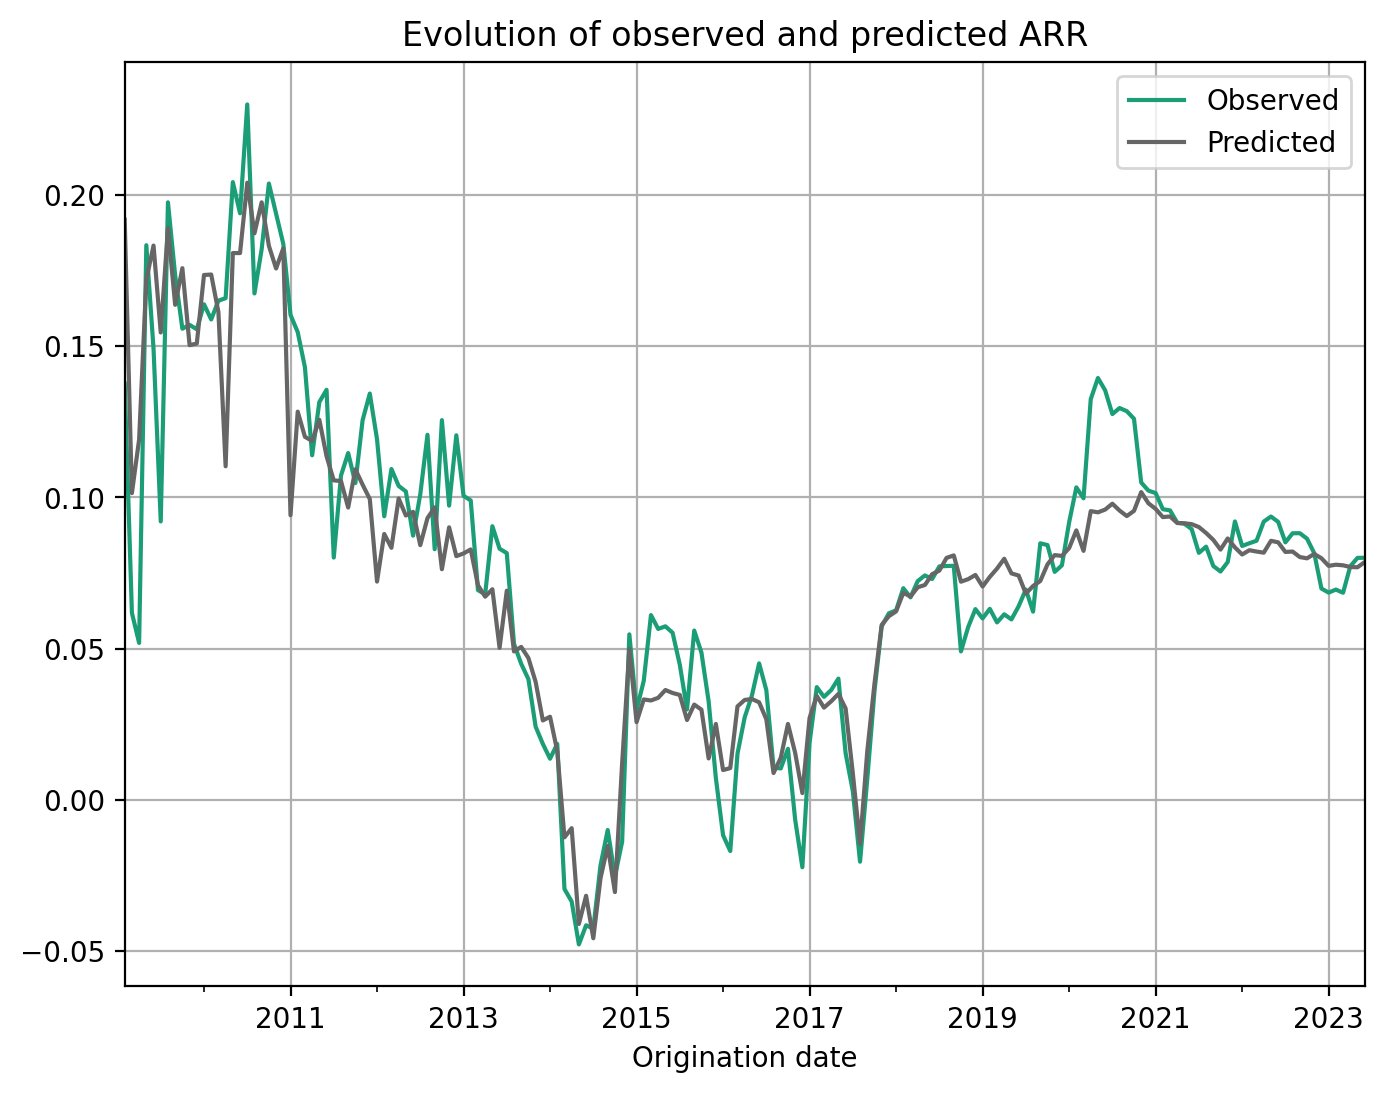

In [48]:
data.groupby('LoanDate')[
    ['risk_adj_ARR', 'ARR_prediction']].mean().rename(
    columns={'risk_adj_ARR': 'Observed', 
             'ARR_prediction': 'Predicted'}).plot(
        title='Evolution of observed and predicted ARR',
        xlabel='Origination date',
        figsize=(8,6), 
        grid=0.05,
        colormap='Dark2')
plt.show()

In [49]:
# select samples for analysis
sample_dt = data[(data['LoanDate'] >= '2014-01-01') \
                    & (data['LoanDate'] < '2016-01-01')][feature_names].copy()

sample_out = data.iloc[~sample_dt.index][feature_names].copy()

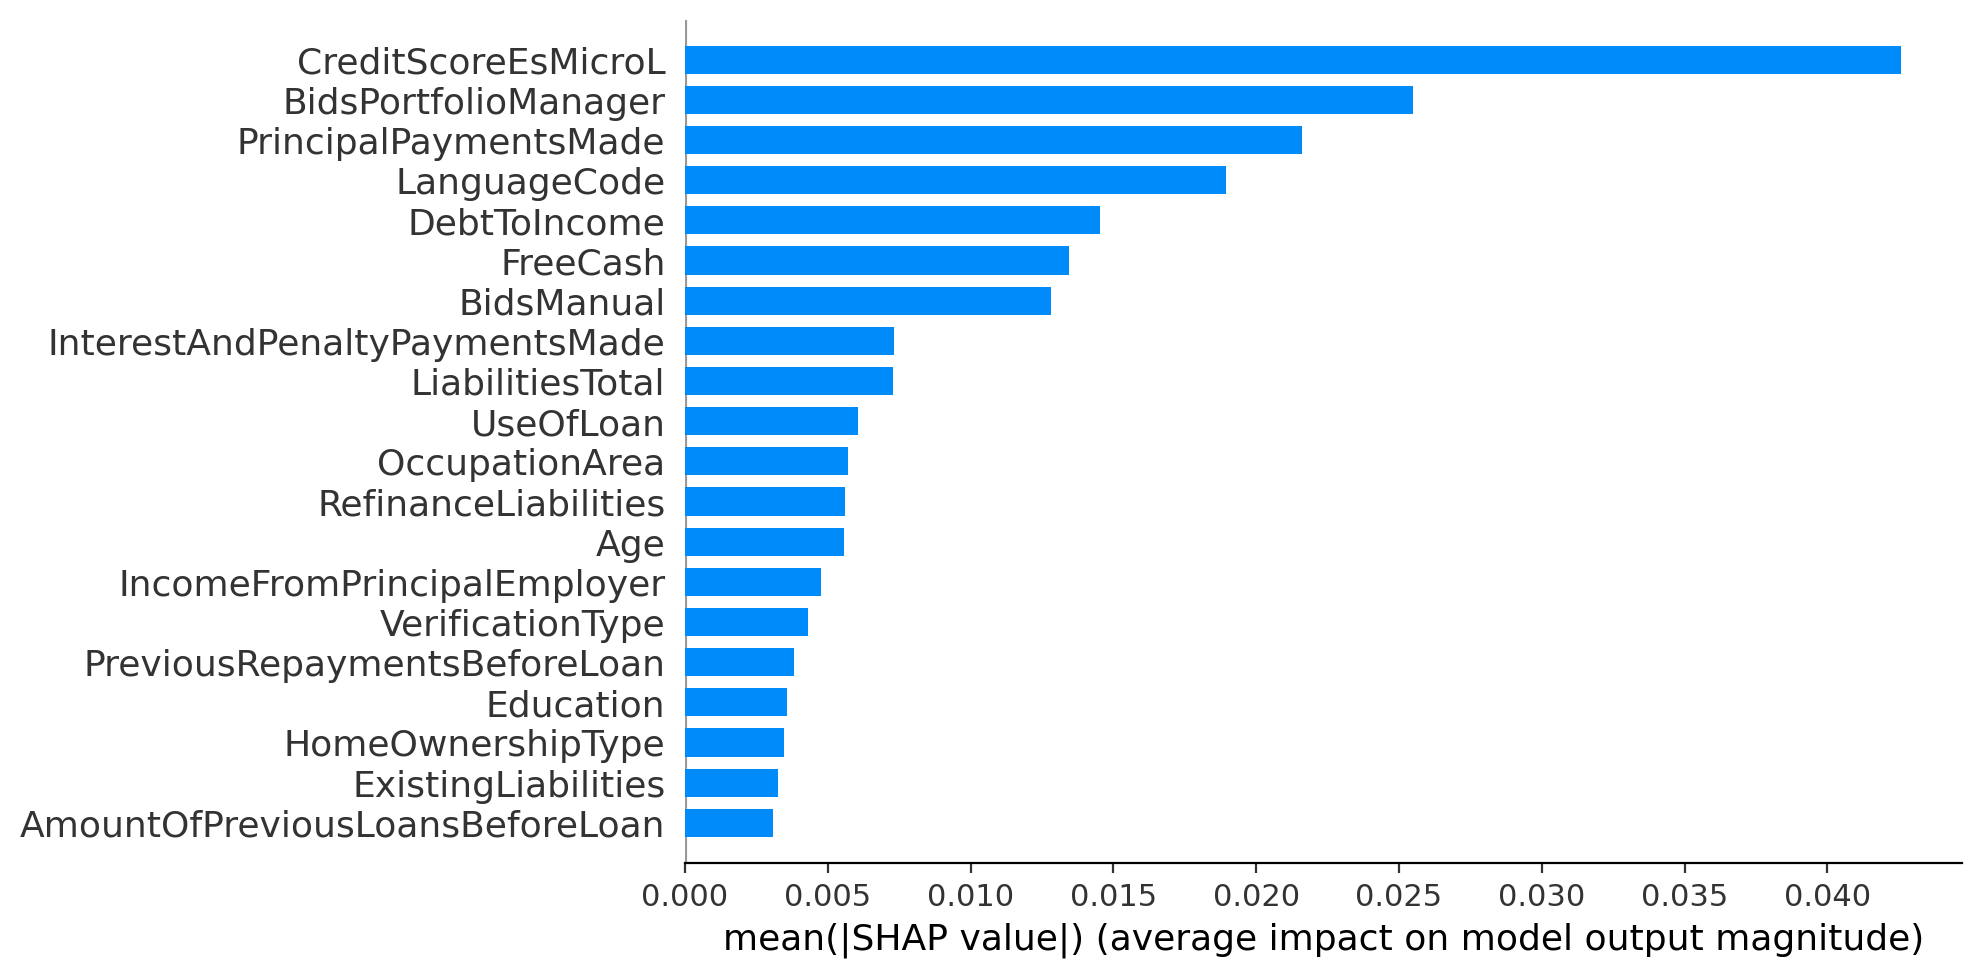

In [50]:
exp = shap.TreeExplainer(lgb_reg)
sv_dt = exp.shap_values(sample_dt)
sv_out = exp.shap_values(sample_out)

# calculate differences
shap_diff = sv_dt - sv_out
shap.summary_plot(shap_diff, X.columns, plot_type='bar', plot_size=(10,5))

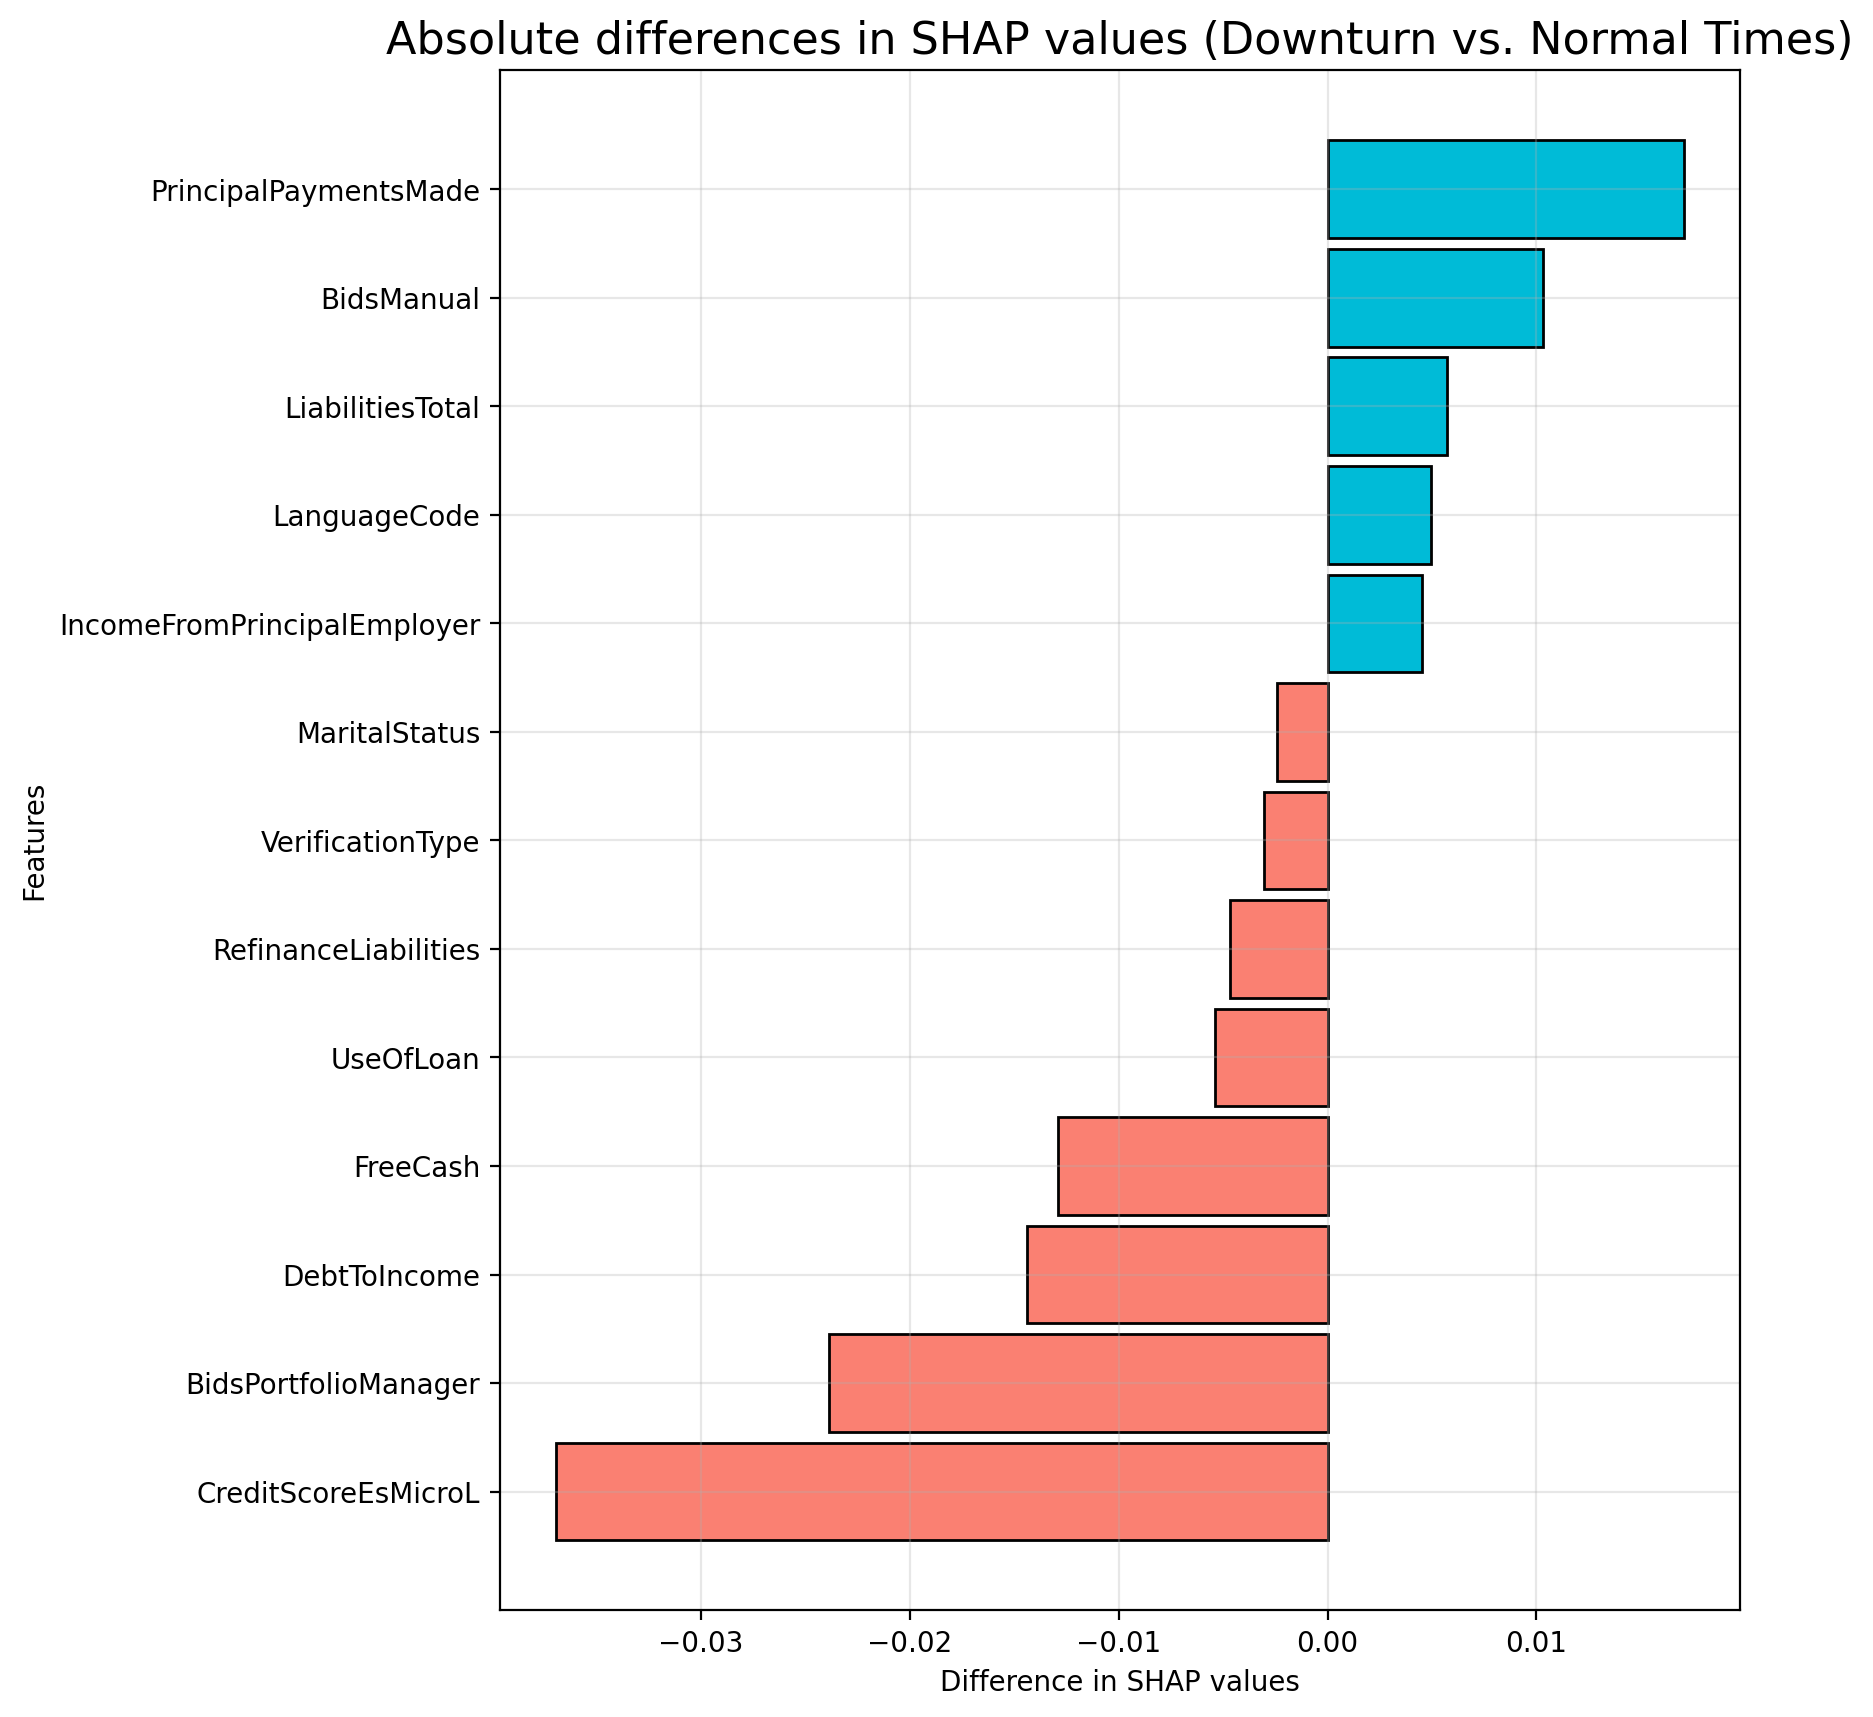

In [52]:
# Calculate the average SHAP values for each feature
avg_shap_dt = sv_dt.mean(axis=0)
avg_shap_out = sv_out.mean(axis=0)

feature_difference = {'feature': [], 
                      'shap_dt': [],
                      'shap_out': []}

# calculate feature-level differences
feature_names = sample_dt.columns
for i, feature in enumerate(feature_names):
    feature_difference['feature'].append(feature)
    feature_difference['shap_dt'].append(avg_shap_dt[i])
    feature_difference['shap_out'].append(avg_shap_out[i])

# Create a dataframe with SHAP outputs
features_shap = pd.DataFrame(feature_difference)
features_shap['difference'] = features_shap['shap_dt'] - features_shap['shap_out']
features_shap['abs_difference'] = abs(features_shap['difference'])
features_shap.sort_values(by='abs_difference', ascending=False, inplace=True)
features_shap = features_shap[0:13].copy()
features_shap.drop(columns='abs_difference', inplace=True)
features_shap.sort_values(by='difference', ascending=True, inplace=True)

# Define colors based on the sign of the difference
colors = ['#FA8072' if d < 0 else '#00BBD7' for d in features_shap['difference']]

# Plot the feature-level differences vertically
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(features_shap['feature'],
        features_shap['difference'],
        height=0.9,
        color=colors,
        edgecolor='black'
        )

ax.grid(alpha=0.3)
ax.set_xlabel('Difference in SHAP values')
ax.set_ylabel('Features')
ax.set_title('Absolute differences in SHAP values (Downturn vs. Normal Times)', 
             fontdict={'fontsize': 16})
plt.show()
# Credit score drives down profitability by 3 percentage points